# Person - EDA and Forecasting

This Notebook is the basis for forecasting object counts given a date and hour. It contains 3 sections:

- **Data preparation**. Here we will compose the dataset and describe the features.
- **Data exploration**. In this section we will start reviewing individual features.
- **Predicting object counts**. Here we will focus on generating an hourly forecast for a given day based on the selected attributes. The aim is to find the most useful model for this task.

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data preparation

The raw data extracted from the images is at the object level. Here are a few sample observations:

In [2]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


Analysis below will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minute intervals are definitely too random and 3 hours reduces the dataset size dramatically. Based on that it seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the `resampling` code snippet below.

In [3]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

# use Pandas handy resample feature to fill in gaps with 0's
object_detections = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
object_detections.columns = ['date_time', 'obs_count']
object_detections['date'] = object_detections['date_time'].dt.date.astype(str)
object_detections['hour'] = object_detections['date_time'].dt.hour
object_detections = object_detections[['date', 'hour', 'obs_count']]
object_detections.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


Now we will strip the dates with the server or power outage

In [4]:
# remove any entries where we know that there was an error in measurements
orig_size = object_detections.shape[0]
idx = object_detections['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
object_detections = object_detections.loc[~idx]
print(f'Removed {orig_size - object_detections.shape[0]} records')

Removed 72 records


Now we can add some useful features based on the date column:

In [5]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.weekday_name
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections['day_of_week_name_short'] = 'WeekDay'
idx = object_detections['day_of_week_name'].isin(['Saturday', 'Sunday'])
object_detections.loc[idx, 'day_of_week_name_short'] = object_detections[idx]['day_of_week_name']
object_detections.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,day_of_week_name_short
0,2019-09-09,7,2,9,2,0,Monday,0,WeekDay
1,2019-09-09,8,3,9,2,0,Monday,0,WeekDay


Next, we can load the Dark Sky weather data extracted from Dark Sky API in the other Notebook.

The idea here is that features from this dataset might be useful to predict the count of observations in a given hour.

#### Warning!

We are bringing-in here the actual weather data.

We need to be careful here, as when system runs in *Production*, it will use the weather forecast (not actuals), which can be wrong.

This variability can be costly and needs special attention down the line.

In [6]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


Next, we can extend the weather data slightly and a few more date/time related features, which will allow us to join the 2 dataframes together in the next step.

In [7]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour
check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


Now we can merge the 2 data sources and verify that all none of the observations was dropped

In [8]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

## Data exploration

Here we will the current shape of the data, all features along with their data types and we will verify if we have any missing data to deal with.

In [9]:
print(f'We have {merged.shape[0]} records with {merged.shape[1]} features')

We have 4140 records with 29 features


In [10]:
nulls = merged.isnull().sum().reset_index()
null_count = nulls[nulls[0] > 0].shape[0]
print (f'We have {null_count} missing values')

We have 0 missing values


Based on the information above, we don't have any missing data. This is good as dealing with missing data is always troublesome and both: removing the rows and imputing the values are never a perfect solution.

In [11]:
# print data types for each of the columns
# print(merged.dtypes)

To keep this Notebook clean I am not printing a summary for the datatypes of all the features, but here is the summary:
- 2 date/time columns
- 5 character-based columns
- 11 integer columns
- 11 floating point columns

Now lets plot the histograms for the selected numerical features and explore their distributions

In [12]:
# select features to inspect
inspect_cols = [
    ['cur__precipIntensity', 'cur__precipProbability', 'cur__temperature', 'cur__apparentTemperature'],
    ['cur__humidity', 'cur__windSpeed', 'cur__windGust', 'cur__windBearing'],
    ['cur__cloudCover', 'cur__uvIndex', 'cur__visibility', 'daily__temperatureHigh']
]
inspect_cols_flat = np.array(inspect_cols).flatten().tolist()

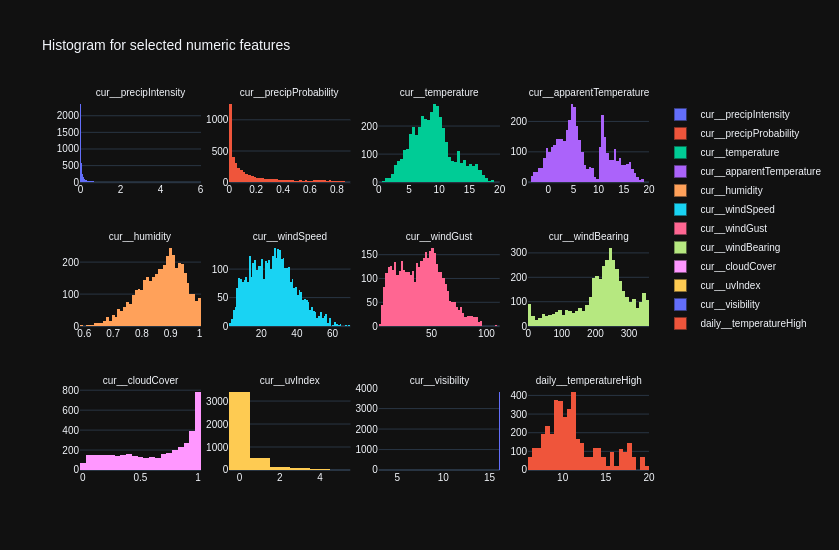

In [13]:
# draw a subplot with a histogram for each feature
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(inspect_cols), cols=len(inspect_cols[0]),
                    subplot_titles=tuple(inspect_cols_flat))
for i, col_set in enumerate(inspect_cols):
    for j, c in enumerate(col_set):
        fig.add_trace(go.Histogram(x=merged[c], name=c), row=i+1, col=j+1)
fig.update_layout(height=550, title_text="Histogram for selected numeric features", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

As we can see, the distibutions vary a lot.

We have some nice almost Gaussian distribution for the temperature, humidity and wind, and we have other distibutions, which follow a very different trends, like precipitation, cloud cover, uv-index and visibility.

If we wanted to use a Linear Model to predict the counts from these features, it would not be able to use more than half of them and we would need to transform the data using one of the known methods:
- square root
- natural logarithm
- reciprocal transformation

Since I will be using a more complex model below, I will not be transforming the data at all and even when transformations were applied, they did not improve the accuracy of prediction models.

#### TODO: Deal with some features containing outliers:
- somehow impute (min, max, mean, median or cap at value) or remove records

## Target variable

What about the values, which we are trying to predict?

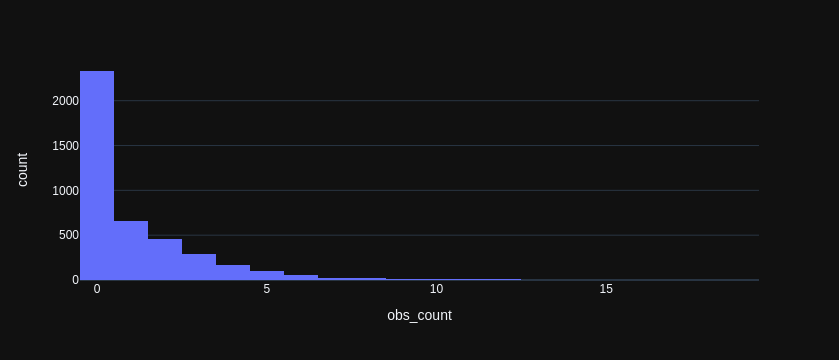

In [47]:
px.histogram(merged, x='obs_count', nbins=int(merged['obs_count'].max()) + 1,
             height=250, width=650)

Since we are modelling the counts, this is a Poisson distibution, and in this case it is a Zero Inflated Poisson case, where 0's dominate the other values.

Poisson is a limiting case of a Binomial distribution with unknown number of trials (it means that trial number goes to infinity).

## Predicting observation counts

It is very useful to generate future predictions for the counts to expect in a full day ahead of time.

Based on this prediction we can inform the user about the situation to expect for the day, and if there is much more objects versus expected counts, we can trigger alerts and potentially prevent an unwanted incident.

My approach to predicting the observation counts for each date and hour is as follows:
- create a simple model without any Machine Learning techniques
- use feature selection techniques to see which features should be included in the ML model
- train a Machine Learning model and calculate error rate
- use Probabilistic Programming to generate predictions with the uncertainty
- try to incorporate engineered features and see if we can increase the model accuracy
- conclude with the method to use going forward

### Simplest model

If we group the dataset by hour and calculate a mean of object counts - then we can convert that mean to the nearest integer and this is the most basic form of a forecast.

$$forecast(X_h)=roundInt(\frac{1}{n}\sum_{i=1}^{n}x_i)$$

Where $X_h$ is the training dataset containing all observations for a given hour $h$, and $n$ is a number of observations in that training set.

Benefits of this type of a basic forecast:
- easy to understand and explain
- fast to compute, requires low resources
- works for each object class without tweaking

Downsides of this forecast:
- it does not take into account any other factors (like weather type or day of week)
- it's skewed by outliers
- it does not provide the uncertainty about the results

#### Implementation:
- split dataset into training and test stes
- calculate means for each hour
- round means to nearest integer
- calculate errors against the test-set (with cross validation):
    - mean absolute error
    - mean squared error
    - r2 score (coefficient of determination)

Error calculations:

$$meanAbsoluteError=\frac{1}{n}\sum_{i=1}^{n}|true-predicted|$$
$$meanSquaredError=\frac{1}{n}\sum_{i=1}^{n}(true-predicted)^2$$
$$rSquared=1-\frac{SS_{res}}{SS_{tot}}$$

Where $SS_{res}$ is the sum of squares of residuals and $SS_{tot}$ is the total sum of squares [(source)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Below is a code snippet, which runs a 5-fold cross validation to calculate mean errors across all the folds.

In [92]:
# use features to create the forecast
X = merged[['hour', 'obs_count']]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
r2s = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    # calculate hourly averages of counts for training set
    mean_obj_counts = X_train.groupby('hour')['obs_count'].mean()
    # now we can generate the predictions for the test set
    y_pred = X_test['hour'].map(mean_obj_counts)
    # round results
    y_pred_rounded = np.array([int(round(p)) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
    r2s.append(r2_score(y_test, y_pred_rounded))
    
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))


mean mse: 2.8857487922705314
mean mae: 0.9272946859903382
mean r2: 0.24398774282746377


As we can see, the Simple Model generated the somewhat dissapointing statistics, but still it allows us to predict how many observations are expected to occur in a given hour.

Now we can ask this model for an hour and it will give us the prediction:

In [91]:
hour = 16
pred = mean_obj_counts[hour]
print(f'Prediction for hour: {hour} is: {pred}, rounded to: {int(round(pred))} objects expected to see.')

Prediction for hour: 16 is: 2.993006993006993, rounded to: 3 objects expected to see.


In [96]:
X.shape

(4140, 2)

### Machine Learning strategy

Predicting object counts is a Supervised Learning Regression problem.

It's Supervised Learning as we do have the data labeled in the historical dataset, and it's a Regression problem as we are predicting a continous variable representing the count of objects.

It's a special case of Regression, and dealing with count of things is known to be a Poisson distibution problem.

I am choosing to investigate 2 Machine Learning strategies inside this Notebook:
- Random Forest regression model (arguably most powerful model available in sklearn repository of ML models)
- Probabilistic model fitting the data to a Poisson distribution (pymc3 library using Monte Carlo sampling, which will give us the predictions and also the uncertainty around them)

#### Note on Neural Networks:

I have not chosen not to use a Neural Network model for forecasting. Neural Networks are more suitable for larger datasets (we have only 4,140 records).

I have tested a standard Feed Forward Neural Network and an Recurrent Neural Network (bidirectional LSTM) sequence prediction model, but they both very quickly overfitted the data and they did not improve the results. They also took much longer to train, they were very sensitive to the parameter choice, and they do not generate the uncertainty about the predictions.

### Feature selection for Machine Learning

Below I will review and compare 3 most popular methods for selecting best features for Machine Learning:
- select K-Best using statistical test
- feature importances
- correlation matrix



#### K-Best features

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

TODO: write documentation about how ANOVA works

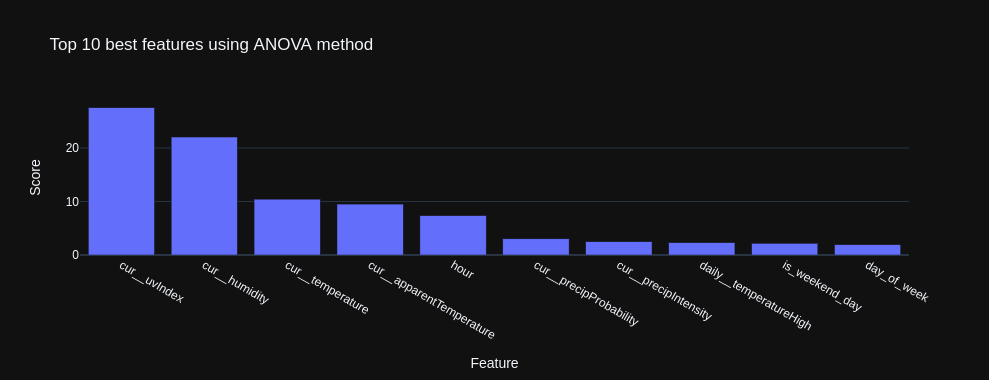

In [144]:
# import necessary libraries
from sklearn.feature_selection import SelectKBest, f_classif

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# extract top 10 features
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X, y)

# import features and scores into a dataframe
top10 = pd.DataFrame([dict(zip(X.columns, fit.scores_))]).T.reset_index().sort_values(0, ascending=False).head(10)
top10.columns = ['Feature', 'Score']

# visualize feature scores
px.bar(top10, x='Feature', y='Score', width=600, height=380, title='Top 10 best features using ANOVA method')

#### Feature importance

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

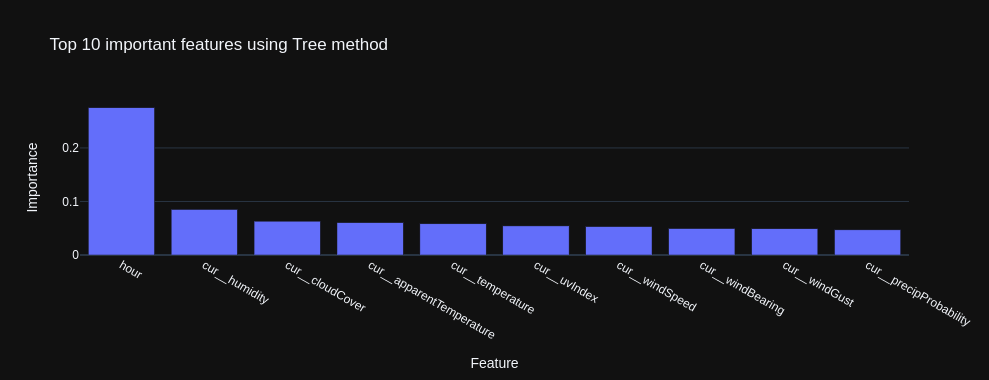

In [145]:
# import necessary libraries
from sklearn.ensemble import ExtraTreesRegressor

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# extract feature importances from the Regressor
model = ExtraTreesRegressor()
_ = model.fit(X, y)

# import features and importances into a dataframe
top10 = pd.DataFrame([dict(zip(X.columns, model.feature_importances_))]).T.reset_index().sort_values(0, ascending=False).head(10)
top10.columns = ['Feature', 'Importance']

# visualize feature importances
px.bar(top10, x='Feature', y='Importance', width=600, height=380, title='Top 10 important features using Tree method')

#### Correlation Matrix

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable). If correlation is near zero, then this feature does not have a direct correlation with the target variable.

Below I will plot the correlations of the features with the `obs_count` target variable.

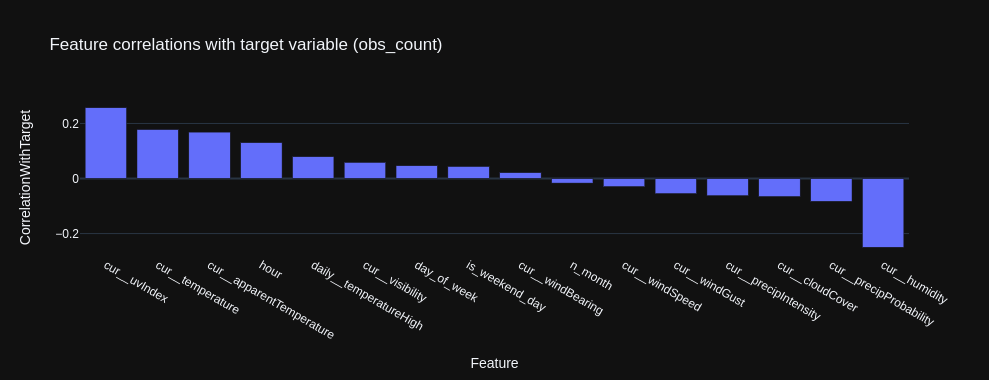

In [185]:
# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat + ['obs_count']
dataset = merged[use_cols]

# get correlations between features in the dataset
corr_mat = dataset.corr()['obs_count'].reset_index().query('index != "obs_count"')
corr_mat.columns = ['Feature', 'CorrelationWithTarget']

# extract correlations and sort them
corrs = corr_mat.sort_values('CorrelationWithTarget', ascending=False)

# plot correlations with obs_count
px.bar(corrs, x='Feature', y='CorrelationWithTarget', width=800, height=380,
       title='Feature correlations with target variable (obs_count)')

### Train Random Forest Model

In [180]:
from sklearn.ensemble import RandomForestRegressor

In [183]:
# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
r2s = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = RandomForestRegressor(n_estimators=300, criterion='mse', n_jobs=6)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
    r2s.append(r2_score(y_test, y_pred_rounded))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))


mean mse: 2.630193236714976
mean mae: 0.8741545893719808
mean r2: 0.30923509212384376


We can observe that using Machine Learning does improve the performance of the model.

Looking at the r2 measure, we can see a 6% improvement (from ~0.24 to ~0.31).

The errors have been not been reduced dramatically, but it should not be expected from a very stochastic in nature dataset.

### Probabilistic Model

There are many benefits from using probabilistic modelling. Some of them are included below:
- it allows us to provide prior information to the model about distributions
- it does not require a lot of data
- it gives us the predictions and the uncertainty about them

Probabilistic modelling uses Bayesian statistics for data analysis and predictions.

#### TODO: provide more theory about Bayesian statistics here

In [ ]:
import pymc3 as pm

In [220]:
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat + ['obs_count']
X = merged[use_cols]
y = merged['obs_count']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Mean: 2.5642857142857145 Std: 2.6313295440857694


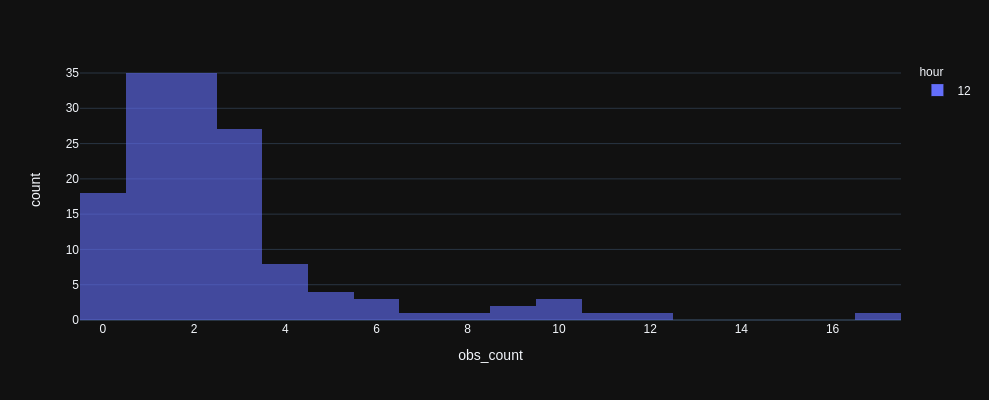

In [354]:
hours = [h for h in range(12, 13)]
hourly_data = X_train[X_train['hour'].isin(hours)]
print('Mean:', hourly_data['obs_count'].mean(), 'Std:', hourly_data['obs_count'].std())
px.histogram(hourly_data, x='obs_count', nbins=20, color='hour', barmode='group',
             opacity=0.6, height=400, width=900)

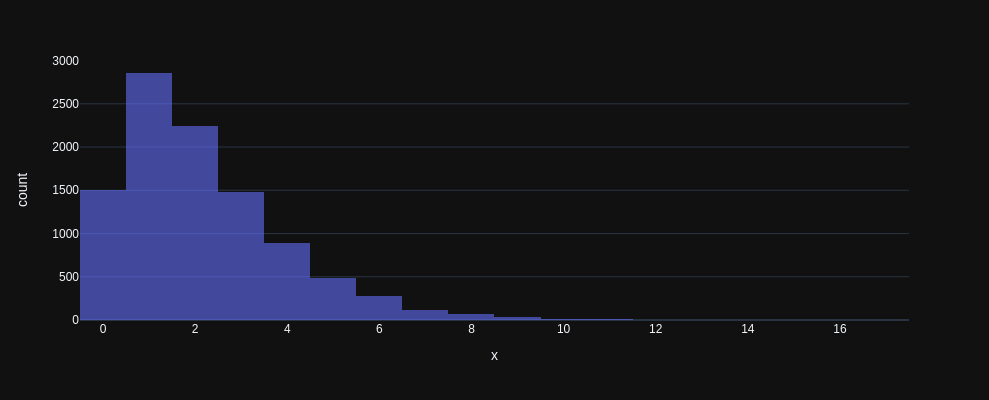

In [355]:
x = pm.HalfStudentT.dist(sigma=2.5, nu=10)
points = x.random(size=10000)
px.histogram(x=points, nbins=20, opacity=0.6, height=400, width=900)

Running for hours: [12]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_prior, sigma_prior]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 5881.87draws/s]


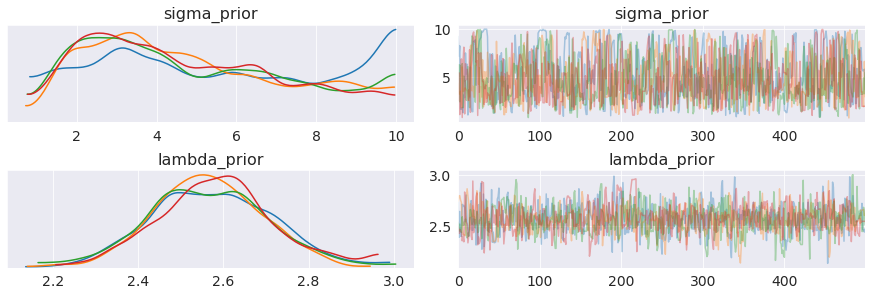

In [356]:
print(f'Running for hours: {hours}')

# fit a pymc3 model to get the rate
basic_model = pm.Model()

with basic_model:
    
    sigma_prior = pm.Uniform('sigma_prior', lower=0, upper=10)
    
    # define prior
    lambda_prior = pm.HalfStudentT('lambda_prior', sigma=sigma_prior, nu=10)

    # define likelihood
    likelyhood = pm.Poisson('Y_obs', mu=lambda_prior, observed=hourly_data['obs_count'].values)

    # sample from posterior
    trace = pm.sample(500, tune=2000, cores=4)
    
    # plot results
    pm.traceplot(trace)
    plt.show()

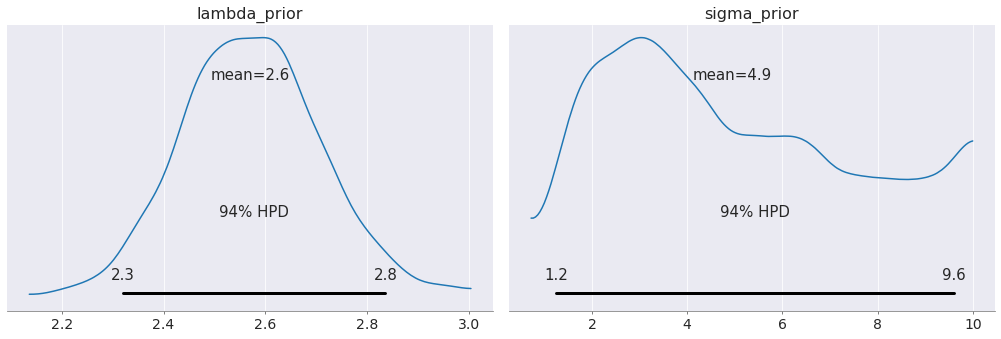

In [357]:
pm.plot_posterior(trace, var_names=['lambda_prior', 'sigma_prior'], credible_interval=0.94);

In [340]:
trace['lambda_prior'].shape

(2000,)

In [341]:
trace['lambda_prior'].min(), trace['lambda_prior'].max()

(1.4416169979644717, 2.2372610782370077)

In [342]:
trace['sigma_prior'].min(), trace['sigma_prior'].max()

(0.5246092471313597, 9.917386667537402)

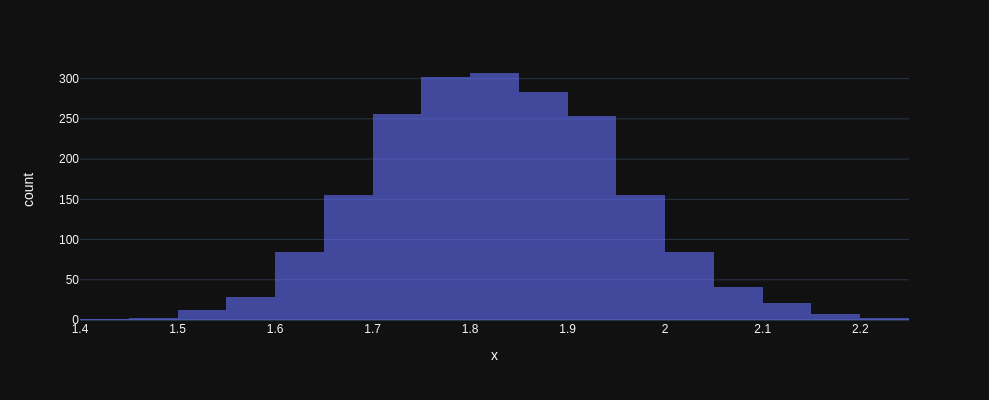

In [344]:
px.histogram(x=trace['lambda_prior'], nbins=20, opacity=0.6, height=400, width=900)

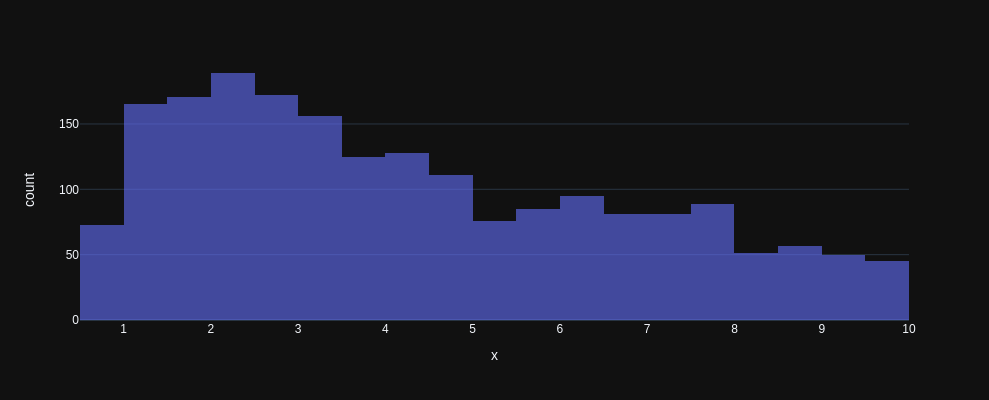

In [343]:
px.histogram(x=trace['sigma_prior'], nbins=20, opacity=0.6, height=400, width=900)

### Additional features engineering

- *is_weekend_day*

We can see in the plot below that during the weekend hours, people tend to sleep longer.

Then the activity becomes much more visible during the latest hours and it eventually sunsets at around 7PM on average.

The difference observed below proves that *is_weekend_day* should be considered as a good feature in the modelling stage.

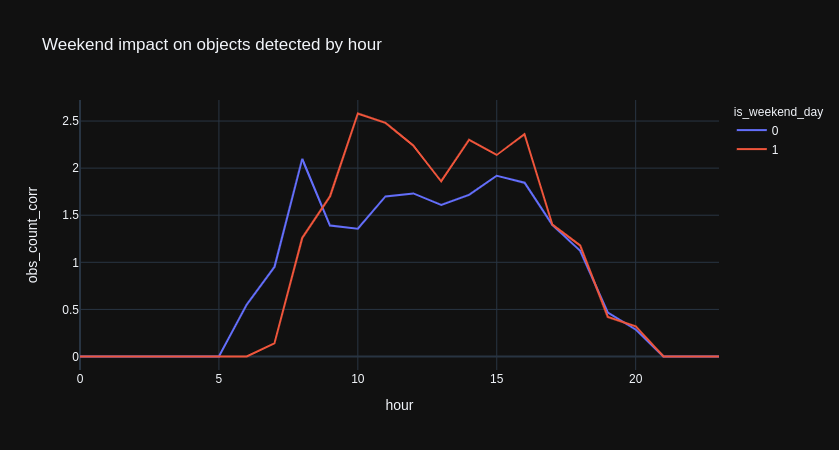

In [57]:
grouped = merged.groupby(['hour', 'is_weekend_day'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="is_weekend_day",
             title='Weekend impact on objects detected by hour')

- *cur__summary*

Does bad weather have an impact on the number of objects?

In [38]:
# define 3 categories of weather: Good, Bad and Perfect
merged['cur_weather_type'] = 'Good'
bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)
merged.loc[bad_idx, 'cur_weather_type'] = 'Bad'

As can be seen in the plot below, when weather is bad - the number of observations is the lowest.

Then, during a good weather, there is a visible increase in the activity.

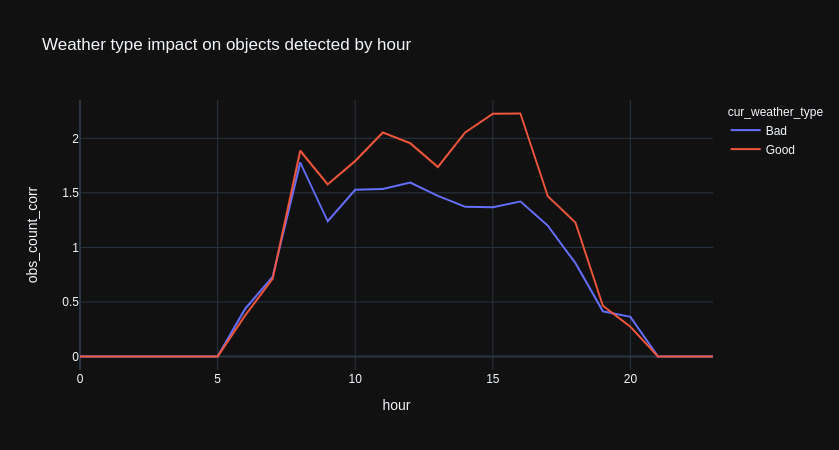

In [39]:
grouped = merged.groupby(['hour', 'cur_weather_type'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="cur_weather_type",
             title='Weather type impact on objects detected by hour')

- *cur__windGust*

Does gust speed affect the number of objects detected in the hourly time intervals?

Firstly we can plot the trend of gusts over time, and based on that we can decide on the threshold to break it down into categories, like Low and Strong.

Then we can see that for most of the time, Strong wind means less activity.

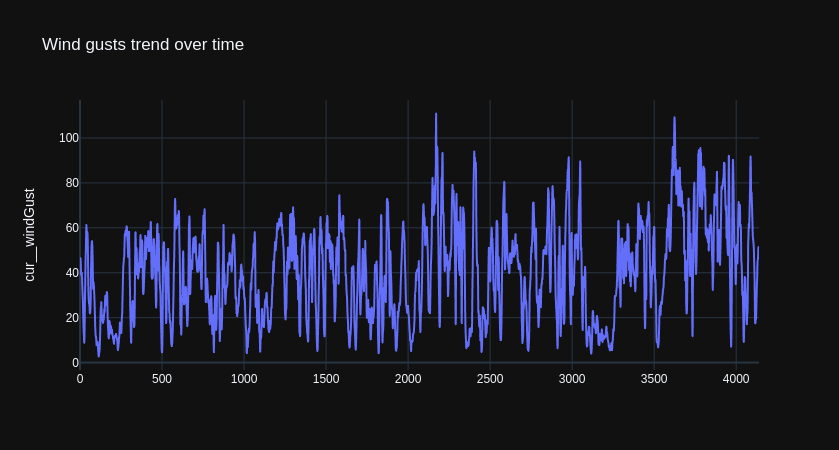

In [40]:
# take a look at the overall wind gust trend
grouped = merged.groupby(['date', 'hour'])['cur__windGust'].mean()
px.line(grouped, y="cur__windGust", height=300,
        title='Wind gusts trend over time')

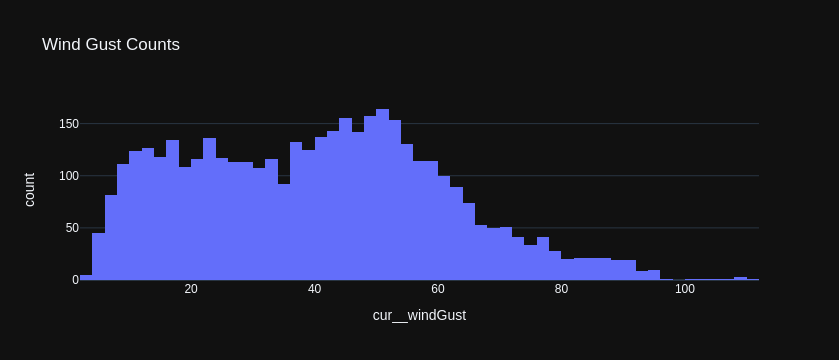

In [41]:
# now see the counts for each potential bucket
px.histogram(grouped, x="cur__windGust", height=300, nbins=100,
             width=600, title='Wind Gust Counts')

In [42]:
# define 2 categories of gusts: Normal and Strong
merged['wind_strength'] = 'Low'
idx = merged['cur__windGust'] >= 50
merged.loc[idx, 'wind_strength'] = 'Strong'

In [43]:
merged['wind_strength'].value_counts()

Low       2755
Strong    1385
Name: wind_strength, dtype: int64

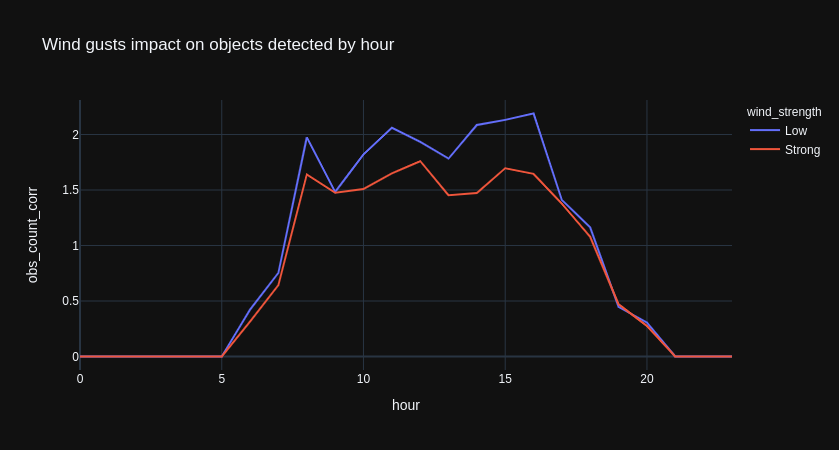

In [44]:
grouped = merged.groupby(['hour', 'wind_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="wind_strength", height=300,
        title='Wind gusts impact on objects detected by hour')

- *cur__precipIntensity*

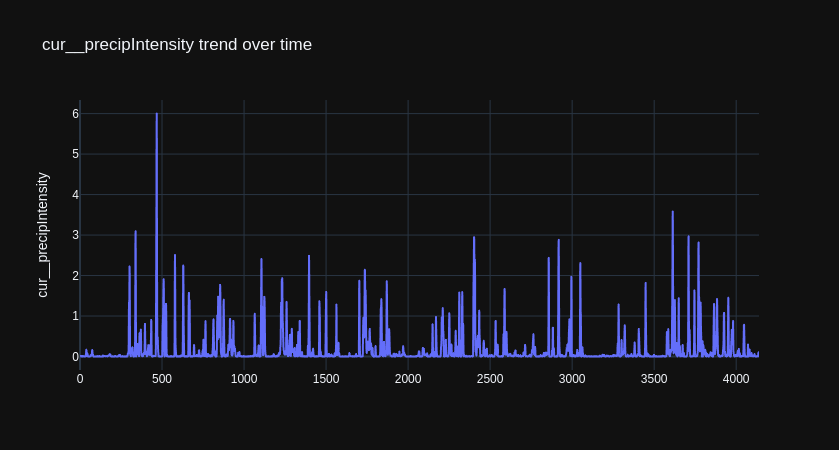

In [45]:
# take a look at the overall trend
grouped = merged.groupby(['date', 'hour'])['cur__precipIntensity'].mean().reset_index()
px.line(grouped, y="cur__precipIntensity", height=300,
        title='cur__precipIntensity trend over time')

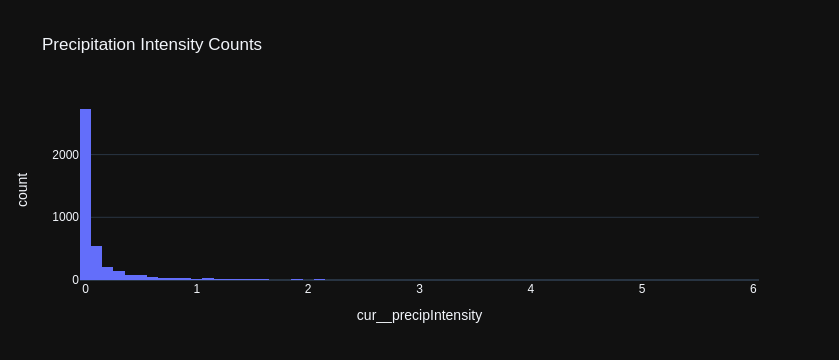

In [49]:
# now see the counts for each potential bucket
px.histogram(grouped, x="cur__precipIntensity", height=300, nbins=100,
             width=600, title='Precipitation Intensity Counts')

Looking at the trend we can see that there are rare events when precipitation is very high.

Breaking it down into 3 buckets confirms that it influences the count of observations.

In [50]:
# define 3 categories of gusts: Normal and Strong
merged['rain_strength'] = 'Low'
idx = merged['cur__precipIntensity'] > 0.1
merged.loc[idx, 'rain_strength'] = 'Higher'

In [51]:
merged['rain_strength'].value_counts()

Low       3093
Higher    1047
Name: rain_strength, dtype: int64

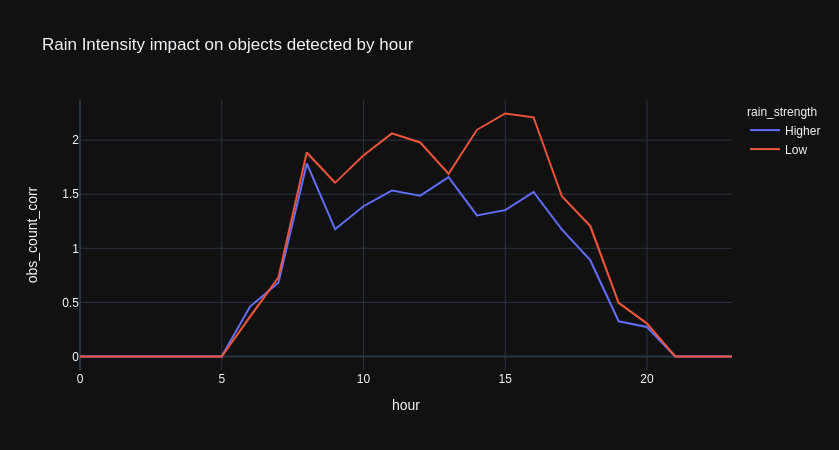

In [52]:
grouped = merged.groupby(['hour', 'rain_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="rain_strength", height=300,
        title='Rain Intensity impact on objects detected by hour')

## Feature encoding

### Numerical features:

Numerical features can be either directly fed into the Machine Learning algorithm, or they can be bucketed into categories based on the domain knowledge. We will use both approaches below.

### Categorical features:

Due to the fact that most of the ML algorithms can not deal with categorical features (like day of week or weather summary), they need to be somehow encoded as numbers. Below are the most common approaches currently used in the industry:

- for nominal encoding (when order does not matter)
    - one hot encoding
    - one hot encoding with many categories
    - mean encoding
- for ordinal encoding (when order matters)
    - label encoding
    - target guided ordinal encoding

### Group numerical features

Next, we can add all numerical columns as a separate dataframe

In [59]:
num_feat = ['is_weekend_day', 'cur__precipIntensity', 'cur__windSpeed', 'cur__windGust',
            'cur__cloudCover', 'cur__apparentTemperature', 'cur__precipProbability']
numerical = merged[num_feat]

### Encode categorical features

Features `cur_weather_type`, `wind_strength`, `rain_strength` and `day_of_week_name` can be treated as nominal for now, and we can encode them using one-hot-encoding technique.

One-hot-encoding takes all values from a feature and turns them into individual columns. A good practice here is to always drop one of the columns, as it can be derived based on other columns.

In [60]:
# One hot encode nominal categorical variables
nom_cat_features = ['cur_weather_type', 'wind_strength', 'rain_strength', 'day_of_week_name_short']
dummies = pd.get_dummies(merged[nom_cat_features], drop_first=False)
dummies.head(2)

,cur_weather_type_Bad,cur_weather_type_Good,wind_strength_Low,wind_strength_Strong,rain_strength_Higher,rain_strength_Low,day_of_week_name_short_Saturday,day_of_week_name_short_Sunday,day_of_week_name_short_WeekDay
0,0,1,1,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0,1


### Deal with cyclical features

How do we deal with features, like: `hour` or `week_number`? Even though they are numerical, they are not a typical numerical, ordinal values and they basically cycle through the time axis.

See this [Kaggle link](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning) for more about this.

In [61]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)    

cycl_feat = ['hour', 'n_week_in_month', 'n_month']
cyclical = merged[cycl_feat].copy()
for col in cycl_feat:
    encode_cyclical(cyclical, col, cyclical[col].max())
    cyclical = cyclical.drop(columns=[col])

In [62]:
cyclical.head(2)

,hour_sin,hour_cos,n_week_in_month_sin,n_week_in_month_cos,n_month_sin,n_month_cos
0,0.942261,-0.33488,0.587785,-0.809017,-1.0,-1.836970e-16
1,0.816970,-0.57668,0.587785,-0.809017,-1.0,-1.836970e-16


### Output (target_ variable)

In [63]:
y = merged['obs_count_corr']

### Encode all selected features

Now, instead of merging all features inside a single dataframe, we can keep them as a tuple of individual dataframes and pickle that data structure.

This will make it easier to pick and choose features in the forecasting Notebook

In [64]:
ret_struct = ((numerical, dummies, cyclical, merged), y)
filename = 'Person_features__2019-09-09_2020-03-02.pickle'
outfile = open(f'../Datasets/{filename}','wb')
pickle.dump(ret_struct, outfile)
outfile.close()